## Preamble

In [ ]:
!pip install pyro-ppl

In [ ]:
import os
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid', 'seaborn-notebook'])
import torch
from torch.nn import Parameter
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroParam
from scipy.cluster.vq import kmeans2

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
# assert pyro.__version__.startswith('0.5.1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

### Plot Utils

In [ ]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                try:
                    mean, cov = model(Xtest, full_cov=True, noiseless=False)
                except:
                    mean, cov = model(Xtest)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

## Data

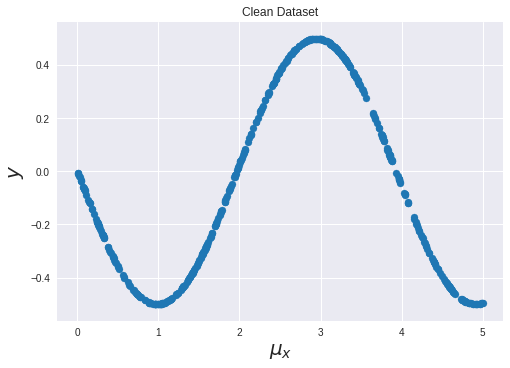

In [ ]:

n_samples = 500
t_samples = 1_000
x_var = 0.1
y_var = 0.05 
X_mu = dist.Uniform(0.0, 5.0).sample(sample_shape=(n_samples,)) 
X_test = torch.linspace(-0.05, 5.05, t_samples)
y_mu = -0.5 * torch.sin(1.6 * X_mu) 

plt.figure()
plt.scatter(X_mu.numpy(), y_mu.numpy())
plt.title('Clean Dataset')
plt.xlabel('$\mu_x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.show()

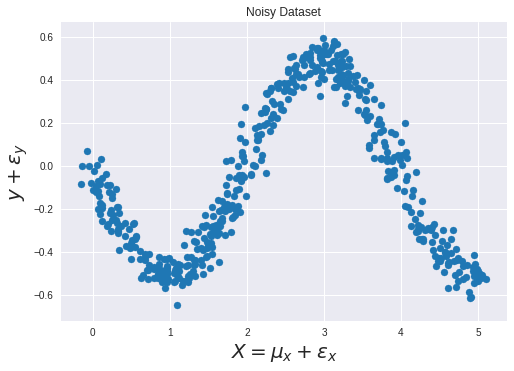

In [ ]:
X = X_mu + dist.Normal(0.0, x_var).sample(sample_shape=(n_samples,))
y = y_mu + dist.Normal(0.0, y_var).sample(sample_shape=(n_samples,))

plt.figure()
plt.scatter(X.numpy(), y.numpy())
plt.title('Noisy Dataset')
plt.xlabel('$X = \mu_x + \epsilon_x$', fontsize=20)
plt.ylabel('$y + \epsilon_y$', fontsize=20)
plt.show()

In [ ]:
X = X.cuda()
y = y.cuda()
X_test = X_test.cuda()

## Variational GP Regression

### Model

In [ ]:
# initialize the inducing inputs (kmeans)
n_inducing = 20.
Xu = kmeans2(X.cpu().numpy(), int(n_inducing), minit="points")[0]
Xu = torch.tensor(Xu)
Xu = Parameter(Xu.clone(), requires_grad=True)
Xu = Xu.cuda()

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# we increase the jitter for better numerical stability
vsgp = gp.models.VariationalSparseGP(
    X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

vsgp.cuda()

VariationalSparseGP(
  (kernel): RBF()
  (likelihood): Gaussian()
)

### Inference

In [ ]:
# the way we setup inference is similar to above
elbo = pyro.infer.TraceMeanField_ELBO()
loss_fn = elbo.differentiable_loss
optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.01)

num_steps = 5_000
losses = gp.util.train(vsgp, num_steps=num_steps, loss_fn=loss_fn, optimizer=optimizer)

### Losses

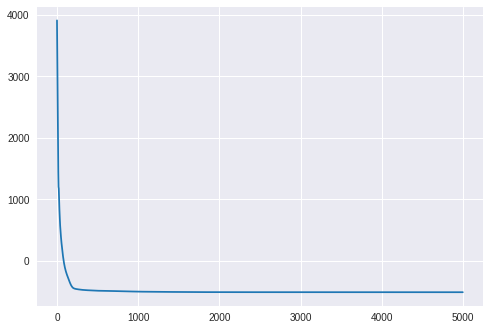

In [ ]:
plt.plot(losses);

### Predictions

In [ ]:
X_plot = torch.sort(X)[0]
with torch.no_grad():
    mean, cov = vsgp(X_test, full_cov=True)
std = cov.diag().sqrt()

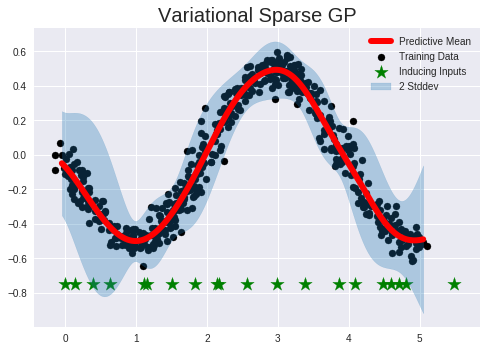

In [ ]:
#@title Figures

plt.figure()

# Training Data
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), color='k', label='Training Data')

# Test Data
plt.plot(X_test.cpu().numpy(), mean.cpu().numpy(), color='r', linewidth=6, label='Predictive Mean')  # plot the mean

# Inducing Points
plt.scatter(vsgp.Xu.cpu().detach().numpy(), -0.75 * torch.ones(int(n_inducing)).cpu().numpy(), color='g', marker='*', s=200, label='Inducing Inputs')

# Confidence Intervals
plt.fill_between(
    X_test.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * std).cpu().numpy(),
    (mean + 2.0 * std).cpu().numpy(),
    color='C0', alpha=0.3,
    label='2 Stddev')

plt.legend(fontsize=10)
plt.title('Variational Sparse GP', fontsize=20)
plt.show()

## Uncertain VSGP

### Method 0 - Standard Prior

In this method I will be imposing the following constraints:

$$
\begin{aligned}
p(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \mathbf{I})\\
q(\mathbf{X}) &\sim \mathcal{N}(\mathbf{m, S})
\end{aligned}
$$

where $\mathbf{S}$ is a free parameter.

#### Model

In [ ]:
# make X a latent variable
Xmu = Parameter(X.clone(), requires_grad=False)

# ==================================
# Inducing Points
# ==================================
n_inducing = 20.

# initialize the inducing inputs (kmeans)
Xu = kmeans2(Xmu.cpu().numpy(), int(n_inducing), minit="points")[0]
Xu = torch.tensor(Xu)

# create parameter
Xu = Parameter(Xu.clone(), requires_grad=True)
Xu = Xu.cuda()

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# we increase the jitter for better numerical stability
gplvm = gp.models.VariationalSparseGP(
    Xmu, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

# ==============================
# Prior Distribution, p(X)
# ==============================

# create priors mu_x, sigma_x 
X_prior_mean = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_prior_std = Parameter(0.1 * torch.ones(Xmu.size()), requires_grad=False).cuda()

# set prior distribution for p(X) as N(Xmu, diag(0.1))
gplvm.X = PyroSample(
    dist.Normal(     # Normal Distribution
    X_prior_mean,    # Prior Mean 
    X_prior_std      # Prior Variance
    ).to_event())


# ==============================
# Variational Distribution, q(X)
# ============================== 

# create guide, i.e. variational parameters
gplvm.autoguide("X", dist.Normal)

# create priors for variational parameters
X_var_loc = Parameter(Xmu.clone(), requires_grad=True).cuda()
X_var_scale = Parameter(x_var * torch.ones((Xmu.shape[0])), requires_grad=True).cuda()

# set quide (variational params) to be N(mu_q, sigma_q)
gplvm.X_loc = X_var_loc
gplvm.X_scale = PyroParam(X_var_scale, dist.constraints.positive)

# Convert to CUDA
gplvm.cuda()

VariationalSparseGP(
  (kernel): RBF()
  (likelihood): Gaussian()
)

#### Inference

In [ ]:
# the way we setup inference is similar to above
elbo = pyro.infer.TraceMeanField_ELBO()
loss_fn = elbo.differentiable_loss
optimizer = torch.optim.Adam(gplvm.parameters(), lr=0.01)

num_steps = 5_000
losses = gp.util.train(gplvm, num_steps=num_steps, loss_fn=loss_fn, optimizer=optimizer)

/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_mean_field_elbo.py:32: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  u
  XGuide sites:
  X
  u
  "Guide sites:\n  " + "\n  ".join(guide_sites))


#### Losses

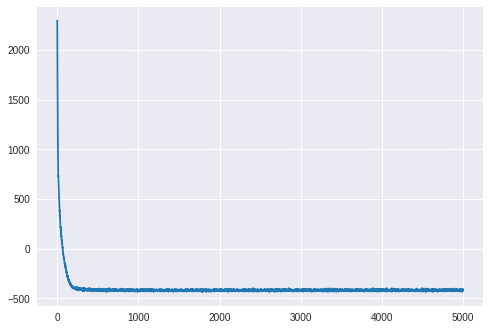

In [ ]:
plt.plot(losses);

In [ ]:
#@title Predictions

X_plot = torch.sort(X)[0]
with torch.no_grad():
    mean, cov = gplvm(X_test, full_cov=True)
std = cov.diag().sqrt()

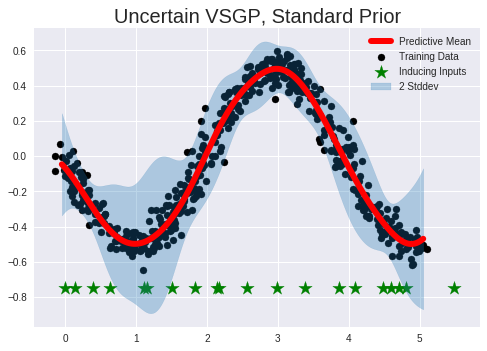

In [ ]:
#@title Figure
plt.figure()

# Training Data
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), color='k', label='Training Data')

# Test Data
plt.plot(X_test.cpu().numpy(), mean.cpu().numpy(), color='r', linewidth=6, label='Predictive Mean')  # plot the mean

# Inducing Points
plt.scatter(vsgp.Xu.cpu().detach().numpy(), -0.75 * torch.ones(int(n_inducing)).cpu().numpy(), color='g', marker='*', s=200, label='Inducing Inputs')

# Confidence Intervals
plt.fill_between(
    X_test.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * std).cpu().numpy(),
    (mean + 2.0 * std).cpu().numpy(),
    color='C0', alpha=0.3,
    label='2 Stddev')

plt.legend(fontsize=10)
plt.title('Uncertain VSGP, Standard Prior', fontsize=20)
plt.show()

### Method III - Bayesian Prior

In this method I will be imposing the following constraints:

$$
\begin{aligned}
p(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \Sigma_x)\\
q(\mathbf{X}) &\sim \mathcal{N}(\mathbf{m,S})
\end{aligned}
$$

where $\mathbf{S}$ is a free parameter.


#### Model

In [ ]:
# make X a latent variable
Xmu = Parameter(X.clone(), requires_grad=False)

# ==================================
# Inducing Points
# ==================================
n_inducing = 20.

# initialize the inducing inputs (kmeans)
Xu = kmeans2(Xmu.cpu().numpy(), int(n_inducing), minit="points")[0]
Xu = torch.tensor(Xu)

# create parameter
Xu = Parameter(Xu.clone(), requires_grad=True)
Xu = Xu.cuda()

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# we increase the jitter for better numerical stability
gplvm = gp.models.VariationalSparseGP(
    Xmu, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

# ==============================
# Prior Distribution, p(X)
# ==============================

# set prior distribution to X to be N(Xmu,I)
X_prior_mean = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_prior_std = Parameter(x_var * torch.ones(Xmu.size()), requires_grad=False).cuda()
gplvm.X = PyroSample(
    dist.Normal(     # Normal Distribution
    X_prior_mean,    # Prior Mean 
    X_prior_std      # Prior Variance
    ).to_event())


# ==============================
# Variational Distribution, q(X)
# ============================== 

# create guide, i.e. variational parameters
gplvm.autoguide("X", dist.Normal)

# create priors for variational parameters
X_var_loc = Parameter(Xmu.clone(), requires_grad=True).cuda()
X_var_scale = Parameter(x_var * torch.ones((Xmu.shape[0])), requires_grad=True).cuda()

# set quide (variational params) to be N(mu_q, sigma_q)
gplvm.X_loc = X_var_loc
gplvm.X_scale = PyroParam(X_var_scale, dist.constraints.positive)
# gplvm.set_constraint("X_scale", dist.constraints.positive)

# Convert to CUDA
gplvm.cuda()

VariationalSparseGP(
  (kernel): RBF()
  (likelihood): Gaussian()
)

#### Inference

In [ ]:
# the way we setup inference is similar to above
optimizer = torch.optim.Adam(gplvm.parameters(), lr=0.01)
num_steps = 5_000
losses = gp.util.train(gplvm, num_steps=num_steps, optimizer=optimizer)

/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_mean_field_elbo.py:32: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  u
  XGuide sites:
  X
  u
  "Guide sites:\n  " + "\n  ".join(guide_sites))


#### Losses

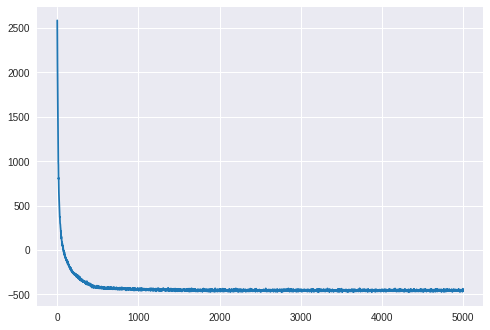

In [ ]:
plt.plot(losses);

#### Predictions

In [ ]:
X_plot = torch.sort(X)[0]
with torch.no_grad():
    mean, cov = gplvm(X_test, full_cov=True)
std = cov.diag().sqrt()

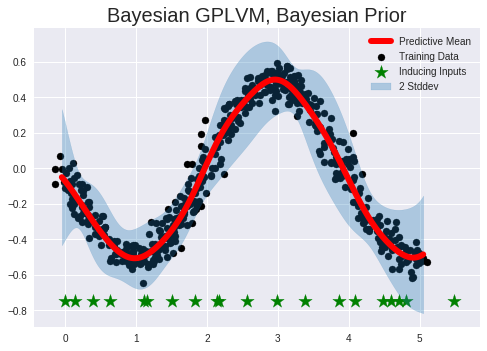

In [ ]:
#@title Figures

plt.figure()

# Training Data
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), color='k', label='Training Data')

# Test Data
plt.plot(X_test.cpu().numpy(), mean.cpu().numpy(), color='r', linewidth=6, label='Predictive Mean')  # plot the mean

# Inducing Points
plt.scatter(vsgp.Xu.cpu().detach().numpy(), -0.75 * torch.ones(int(n_inducing)).cpu().numpy(), color='g', marker='*', s=200, label='Inducing Inputs')

# Confidence Intervals
plt.fill_between(
    X_test.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * std).cpu().numpy(),
    (mean + 2.0 * std).cpu().numpy(),
    color='C0', alpha=0.3,
    label='2 Stddev')

plt.legend(fontsize=10)
plt.title('Bayesian GPLVM, Bayesian Prior', fontsize=20)
plt.show()

### Method I - Strong Conservative Prior

In this method I will be imposing the following constraints:

$$
\begin{aligned}
p(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \mathbf{I})\\
q(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \Sigma_x)
\end{aligned}
$$

#### Model

In [ ]:
# make X a latent variable
Xmu = Parameter(X.clone(), requires_grad=False)

# ==================================
# Inducing Points
# ==================================
n_inducing = 20.

# initialize the inducing inputs (kmeans)
Xu = kmeans2(Xmu.cpu().numpy(), int(n_inducing), minit="points")[0]
Xu = torch.tensor(Xu)

# create parameter
Xu = Parameter(Xu.clone(), requires_grad=True)
Xu = Xu.cuda()

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# we increase the jitter for better numerical stability
gplvm = gp.models.VariationalSparseGP(
    Xmu, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

# ==============================
# Prior Distribution, p(X)
# ==============================

# set prior distribution to X to be N(Xmu,I)
X_prior_mean = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_prior_std = Parameter(0.05 * torch.ones(Xmu.size()), requires_grad=False).cuda()
gplvm.X = PyroSample(
    dist.Normal(     # Normal Distribution
    X_prior_mean,    # Prior Mean 
    X_prior_std      # Prior Variance
    ).to_event())


# ==============================
# Variational Distribution, q(X)
# ============================== 

# create guide, i.e. variational parameters
gplvm.autoguide("X", dist.Normal)

# create priors for variational parameters
X_var_loc = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_var_scale = Parameter(x_var * torch.ones((Xmu.shape[0])), requires_grad=False).cuda()

# set quide (variational params) to be N(mu_q, sigma_q)
gplvm.X_loc = X_var_loc
gplvm.X_scale = PyroParam(X_var_scale, dist.constraints.positive)

# Convert to CUDA
gplvm.cuda()

VariationalSparseGP(
  (kernel): RBF()
  (likelihood): Gaussian()
)

#### Inference

In [ ]:
# the way we setup inference is similar to above
optimizer = torch.optim.Adam(gplvm.parameters(), lr=0.01)
num_steps = 5_000
losses = gp.util.train(gplvm, num_steps=num_steps, optimizer=optimizer)

#### Losses

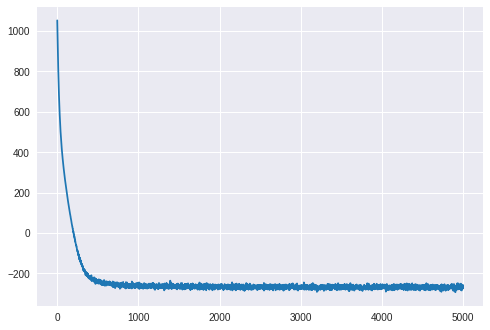

In [ ]:
plt.plot(losses);

#### Predictions

In [ ]:
X_plot = torch.sort(X)[0]
with torch.no_grad():
    mean, cov = gplvm(X_test, full_cov=True)
std = cov.diag().sqrt()

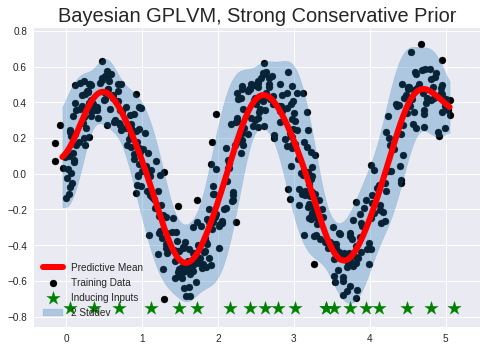

In [ ]:
plt.figure()

# Training Data
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), color='k', label='Training Data')

# Test Data
plt.plot(X_test.cpu().numpy(), mean.cpu().numpy(), color='r', linewidth=6, label='Predictive Mean')  # plot the mean

# Inducing Points
plt.scatter(vsgp.Xu.cpu().detach().numpy(), -0.75 * torch.ones(int(n_inducing)).cpu().numpy(), color='g', marker='*', s=200, label='Inducing Inputs')

# Confidence Intervals
plt.fill_between(
    X_test.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * std).cpu().numpy(),
    (mean + 2.0 * std).cpu().numpy(),
    color='C0', alpha=0.3,
    label='2 Stddev')

plt.legend(fontsize=10)
plt.title('Bayesian GPLVM, Strong Conservative Prior', fontsize=20)
plt.show()

### Method II - Strong Prior

In this method I will be imposing the following constraints:

$$
\begin{aligned}
p(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \Sigma_x)\\
q(\mathbf{X}) &\sim \mathcal{N}(\mu_x, \Sigma_x)
\end{aligned}
$$



#### Model

In [ ]:
# make X a latent variable
Xmu = Parameter(X.clone(), requires_grad=False)

# ==================================
# Inducing Points
# ==================================
n_inducing = 20.

# initialize the inducing inputs (kmeans)
Xu = kmeans2(Xmu.cpu().numpy(), int(n_inducing), minit="points")[0]
Xu = torch.tensor(Xu)

# create parameter
Xu = Parameter(Xu.clone(), requires_grad=True)
Xu = Xu.cuda()

# initialize the kernel and model
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# we increase the jitter for better numerical stability
gplvm = gp.models.VariationalSparseGP(
    Xmu, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
)

# ==============================
# Prior Distribution, p(X)
# ==============================

# set prior distribution to X to be N(Xmu,I)
X_prior_mean = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_prior_std = Parameter(x_var * torch.ones(Xmu.size()), requires_grad=False).cuda()
gplvm.X = PyroSample(
    dist.Normal(     # Normal Distribution
    X_prior_mean,    # Prior Mean 
    X_prior_std      # Prior Variance
    ).to_event())


# ==============================
# Variational Distribution, q(X)
# ============================== 

# create guide, i.e. variational parameters
gplvm.autoguide("X", dist.Normal)

# create priors for variational parameters
X_var_loc = Parameter(Xmu.clone(), requires_grad=False).cuda()
X_var_scale = Parameter(x_var * torch.ones((Xmu.shape[0])), requires_grad=False).cuda()

# set quide (variational params) to be N(mu_q, sigma_q)
gplvm.X_loc = X_var_loc
gplvm.X_scale = PyroParam(X_var_scale, dist.constraints.positive)

# Convert to CUDA
gplvm.cuda()

VariationalSparseGP(
  (kernel): RBF()
  (likelihood): Gaussian()
)

#### Inference

In [ ]:
# the way we setup inference is similar to above
optimizer = torch.optim.Adam(gplvm.parameters(), lr=0.01)
num_steps = 5_000
losses = gp.util.train(gplvm, num_steps=num_steps, optimizer=optimizer)

#### Losses

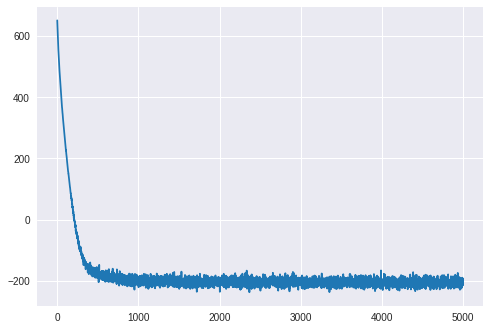

In [ ]:
plt.plot(losses);

#### Predictions

In [ ]:
X_plot = torch.sort(X)[0]
with torch.no_grad():
    mean, cov = gplvm(X_test, full_cov=True)
std = cov.diag().sqrt()

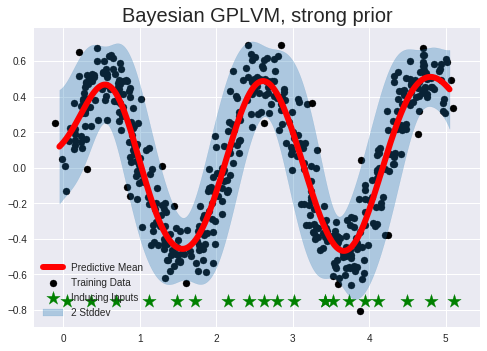

In [ ]:
plt.figure()

# Training Data
plt.scatter(X.cpu().numpy(), y.cpu().numpy(), color='k', label='Training Data')

# Test Data
plt.plot(X_test.cpu().numpy(), mean.cpu().numpy(), color='r', linewidth=6, label='Predictive Mean')  # plot the mean

# Inducing Points
plt.scatter(vsgp.Xu.cpu().detach().numpy(), -0.75 * torch.ones(int(n_inducing)).cpu().numpy(), color='g', marker='*', s=200, label='Inducing Inputs')

# Confidence Intervals
plt.fill_between(
    X_test.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * std).cpu().numpy(),
    (mean + 2.0 * std).cpu().numpy(),
    color='C0', alpha=0.3,
    label='2 Stddev')

plt.legend(fontsize=10)
plt.title('Bayesian GPLVM, strong prior', fontsize=20)
plt.show()